# Image Classification with CIFAR-10 dataset
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

#### Some references to look up
- [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html): labeled subsets of the 80 million tiny images dataset. 
- [urlretrieve lib](https://docs.python.org/3.0/library/urllib.request.html): copy a network object denoted by a URL to a local file, if necessary
- [tarfile lib](https://docs.python.org/2/library/tarfile.html): makes it possible to read and write tar archives, including those using gzip or bz2 compression.
- [tqdm lib](https://pypi.python.org/pypi/tqdm): Fast, Extensible Progress Meter

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Before Jumping in

### Some references to look up
- [python pickle](https://docs.python.org/3/library/pickle.html): implements binary protocols for serializing and de-serializing a Python object structure.
- [numpy reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html): Gives a new shape to an array without changing its data.
- [numpy transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html): Permute the dimensions of an array.
- [numpy transpose with list of axes explanation](https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array)
- [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d): check out input with the argument, data_format. "NHWC": [batch, height, width, channels], "NCHW": [batch, channels, height, width].
- [row major order explanation](https://en.wikipedia.org/wiki/Row-_and_column-major_order)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### List of files 

![](./list_of_batch_files.png)

As seen above picture, the dataset is broken into batches to **prevent** your machine from running **out of memory**. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:

### Understanding the original data 

The original a batch data is (10000 x 3072) dimensional tensor expressed in numpy array, where the number of columns, (10000), indicates the number of sample data. As stated in the [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), the row vector, (3072) represents an color image of 32x32 pixels. Since this project is going to use CNN for the classification tasks, the row vector, (3072), is not an appropriate form of image data to feed. In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). It depends on your choice (check out the [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)). In this particular project, I am going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.

[O] need to be modified into a new shape

### Understanding the original labels

The label data is just a list of 10000 numbers in the range 0-9, which corresponds to each of the 10 classes in CIFAR-10. 

* **airplane**
* **automobile**
* **bird**
* **cat**
* **deer**
* **dog**
* **frog**
* **horse**
* **ship**
* **truck**

[X] need to be modified into a new shape


In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### How to reshape into a such form?

The row vector (3072) has the exact same number of elements if you calculate 32\*32\*3==3072. In order to reshape the row vector, (3072), there are two steps required. The **first** step is involved with using **reshape** function in numpy, and the **second** step is involved with using **transpose** function in numpy as well.

By definition from the official web site, **reshape** function gives a new shape to an array without changing its data. Here, the phrase **without changing its data** is an important part. **reshape** operations should be delivered in three more detailed step. The following direction is described in a logical concept. 

1. divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
  - this results in (3 x 1024) dimension of tensor
2. divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - this results in (3 x 32 x 32)

In order to implement the directions written in logical sense in numpy, **reshape** function should be called in the following arguments, (10000, 3, 32, 32). As you noticed, reshape function doesn't automatically divide further when the third value (32, width) is provided. We need to explicitly specify the value for the last value (32, height)


This is not the end of story. Now, the image data is represented as (num_channel, width, height) form. However, **this is not the shape tensorflow and matplotlib are expecting**. They are expecting different shape of (width, height, num_channel) instead. We need to swap the order of each axes, and that is where **transpose** function comes in.

The **transpose** function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

<img src="./reshape-transpose.png" alt="Drawing" style="width: 800px;"/>

In [4]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore the Data

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

The display_stats defined below answers some of questions like in a given batch of data..
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"


In [5]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


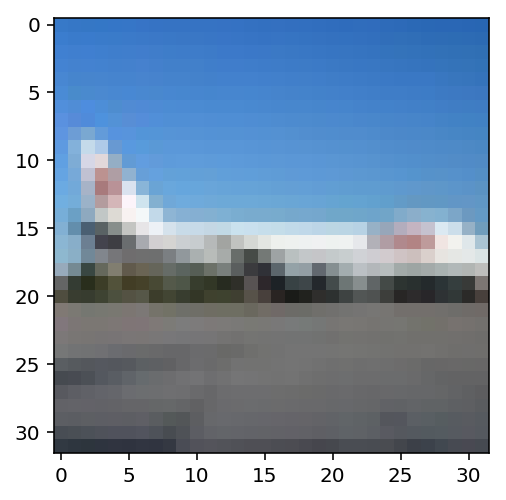

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
**Min-Max Normalization**
- this simply makes all x values to range between 0 and 1.
- y = (x-min) / (max-min)

**Some references to look up**
- [Min-Max Normalization](https://www.quora.com/What-is-the-meaning-of-min-max-normalization)
- [Watch "why normalizing inputs"](https://www.youtube.com/watch?v=FDCfw-YqWTE)
- [Exploding, Vainishing Gradient descent](https://www.youtube.com/watch?v=qhXZsFVxGKo)

`normalize` function takes an image data, `x`, and returns it as a normalized Numpy array. The values in the original data is going to be transformed in range of 0 to 1, inclusive without change the shape of the array. A simply answer to why normalization should be performed is somewhat related to activation function.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png" alt="Drawing" style="width: 300px;"/>

For another example, ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_4/Relu.jpeg" alt="Drawing" style="width: 300px;"/>

Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. When backpropagation process is performed to optimize the networks, this could lead to an exploding gradient which leads to an aweful learning steps. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [7]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### One-hot encode

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of 10 too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

**`one_hot_encode`** function takes the input, **`x`**, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. **`one_hot_encode`** function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

#### some references to look up
- [one hot encoding](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)

In [8]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## Preprocess all the data and save it

The code cell below uses the previously implemented functions, normalize and one_hot_encode, to preprocess the given dataset.
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation. 

<img src="./train-valid-test split.png" alt="Drawing" style="width: 700px;"/>

In [9]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [10]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Checkpoint


In [11]:
import pickle
import problem_unittests as tests
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

#### some references to look up
- [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers)
- [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers)
- [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.


Note: You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.  You're free to use any TensorFlow package for all the other layers.

In [12]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights = tf.Variable(tf.truncated_normal(shape=[conv_ksize[0], conv_ksize[1], int(x_tensor.shape[3]), conv_num_outputs], 
                                                          mean=0, stddev=0.08))
    
    biases = tf.Variable(tf.zeros([conv_num_outputs]))
    
    strides = [1, conv_strides[0], conv_strides[1], 1]
    
    conv = tf.nn.conv2d(x_tensor,
                        weights, 
                        strides=strides, 
                        padding='SAME')
    
    conv = tf.nn.bias_add(conv, biases)
    
    conv = tf.nn.relu(conv)
    
    pool_size = [1, pool_ksize[0], pool_ksize[1], 1]
    pool_strides = [1, pool_strides[0], pool_strides[1], 1]
    
    conv = tf.nn.max_pool(conv, 
                          ksize=pool_size, 
                          strides=pool_strides, 
                          padding='SAME')
    
    return conv


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

NameError: name 'tf' is not defined

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [13]:
import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], mean=0, stddev=0.08))

    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,1,1,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    flat = tf.contrib.layers.flatten(conv4_bn)  

    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=64, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=128, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=256, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

tests.test_conv_net(conv_net)

Neural Network Built!


In [14]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that can be loaded from disk after training
model = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [17]:
epochs = 15
batch_size = 128
keep_probability = 0.7

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [ ]:
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Epoch  1, CIFAR-10 Batch 1:  

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [64]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2085 Validation Accuracy: 0.212600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8107 Validation Accuracy: 0.245600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7291 Validation Accuracy: 0.313800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6600 Validation Accuracy: 0.359000
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.6590 Validation Accuracy: 0.403200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.7614 Validation Accuracy: 0.408800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3296 Validation Accuracy: 0.437200
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.2989 Validation Accuracy: 0.458800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.3421 Validation Accuracy: 0.462400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.3294 Validation Accuracy: 0.503400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4014 Validation Accuracy: 0.495200
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.1166 Validation Accuracy: 0.489800
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.0990 Validation Accuracy: 0.510000


KeyboardInterrupt: 

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.5882762738853503



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


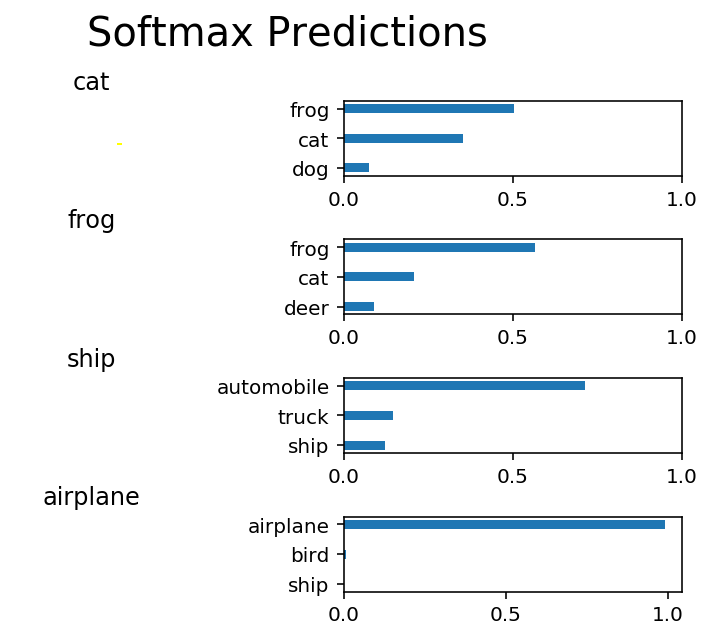

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-70% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.